In [30]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Some useful functions

In [31]:
def all_gammas(Xw, Es, adjlist, idx, adjlist_labels):

    N = int(len(Xw)/2)
    x_gat = np.zeros(len(Xw))
    x_gcn = np.zeros(len(Xw))
    
    gammas_intra = []
    gammas_inter = []
    
    for i in range(len(Xw)):
                                 
        psi_function = Es[idx[i]:idx[i] + len(adjlist[i])]
        temp = psi_function - (psi_function).max()
        ex = np.exp(temp)
        gammas_gat = ex / np.sum(ex)          
        gammas_intra.append(list(gammas_gat[adjlist_labels[idx[i]:idx[i] + len(adjlist[i])]]))
        gammas_inter.append(list(gammas_gat[list(~np.array(adjlist_labels[idx[i]:idx[i] + len(adjlist[i])]))]))
        
        x_gat[i] = np.dot(gammas_gat, Xw[adjlist[i]])
        
        gammas_gcn = np.ones(len(adjlist[i]))/len(adjlist[i])
        x_gcn[i] = np.dot(gammas_gcn, Xw[adjlist[i]])
            
    return x_gat, x_gcn, gammas_intra, gammas_inter

# Create data positive result

In [36]:
n = 400
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.4

sizes = [int(n/2), int(n/2)]

std_ = 0.1
zeta = 0.1

p = 0.4
q = 0.33

mu_up = 20*std_*np.sqrt(np.log(n))/(2*np.sqrt(d))
mu_lb = 0.01*((p+q)/(np.abs(p-q)))*std_*np.sqrt(np.log(n)/max(n*p,n*q))/(2*np.sqrt(d))
mus = np.geomspace(mu_lb, mu_up, 30, endpoint=True)

ground_truth = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

acc_gat = []
acc_gcn = []

acc_gat_std = []
acc_gcn_std = []

avg_gammas_intra = []
std_gammas_intra = []

avg_gammas_inter = []
std_gammas_inter = []

trials = 50

for mu in mus:
    
    print(mu/mus[-1])
    
    acc_gat_list = []
    acc_gcn_list = []
    
    probs = [[p,q], [q,p]]
    
    all_gammas_intra = []
    all_gammas_inter = []
    
    for trial in range(trials):
        g = nx.stochastic_block_model(sizes, probs)
        n_edges = g.number_of_edges()
        
        nu = 0.1*zeta/(2*np.sqrt(d))

        adjlist = [[v for v in g.neighbors(i)] for i in range(n)]
        tmp = [[ground_truth[v] == ground_truth[i] for v in g.neighbors(i)] for i in range(n)]
        adjlist_labels = []
        for i in range(n):
            adjlist_labels += tmp[i]
        adjlist_labels = np.asarray(adjlist_labels)
        m = len(adjlist_labels)
        idx = np.zeros(n, dtype=int)
        for i in range(n-1):
            idx[i+1] = idx[i] + len(adjlist[i])

        X = np.zeros((n,d))
        X[:int(n/2)] = -mu
        X[int(n/2):] = mu
        noise = std_*np.random.randn(n,d)
        X = X + noise
        
        E = nu*np.ones(m*d)
        E = np.reshape(E, (m,d))*(2*adjlist_labels[:, np.newaxis]-1)
        noise = zeta*np.random.randn(m,d)
        E = E + noise

        R = 1
        mu_ = mu*np.ones(d)
        w = np.sign(p-q)*(R/np.linalg.norm(mu_))*mu_
        Xw = X@w
        
        R = 1
        nu_ = nu*np.ones(d)
        s = np.sign(p-q)*(R/np.linalg.norm(nu_))*nu_
        Es = E@s

        x_gat, x_gcn, gammas_intra, gammas_inter = all_gammas(Xw, Es, adjlist, idx, adjlist_labels)  
        
        [all_gammas_intra.extend(tmp) for tmp in gammas_intra] 
        [all_gammas_inter.extend(tmp) for tmp in gammas_inter] 
        
        pred = np.zeros(n)
        pred[x_gat > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gat_list.append(tmp)
        
        pred = np.zeros(n)
        pred[x_gcn > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gcn_list.append(tmp)
    
    acc_gat.append(np.asarray(acc_gat_list).mean())
    acc_gcn.append(np.asarray(acc_gcn_list).mean())
    
    acc_gat_std.append(np.asarray(acc_gat_list).std())
    acc_gcn_std.append(np.asarray(acc_gcn_list).std())
    
    avg_gammas_intra.append(np.asarray(all_gammas_intra).mean())
    std_gammas_intra.append(np.asarray(all_gammas_intra).std())
    
    avg_gammas_inter.append(np.asarray(all_gammas_inter).mean())
    std_gammas_inter.append(np.asarray(all_gammas_inter).std())
    

0.00041222548070052084
0.0005393296811209413
0.000705624757702293
0.0009231946916913096
0.0012078493979467161
0.0015802735666162824
0.002067529734742898
0.0027050248098492735
0.00353908294470551
0.004630311723537699
0.006058006266624722
0.007925911281503285
0.01036975976541238
0.013567136165567848
0.017750380712675953
0.023223472632682252
0.03038411907051626
0.03975265483733486
0.05200985300738003
0.068046393905465
0.08902758719353963
0.11647805014494299
0.15239249532927224
0.19938067819459057
0.26085703729335163
0.3412888075295514
0.4465206357992773
0.58419928751202
0.7643293056739482
1.0


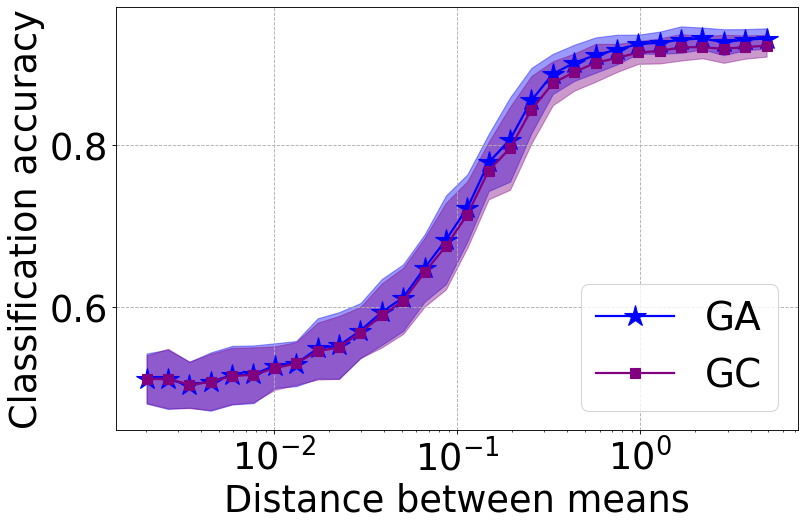

In [37]:
import math

fig = plt.figure(figsize=(11, 7), dpi=80)

val = (2*np.sqrt(d))
plt.plot(mus*val,acc_gat, linewidth=2, linestyle='-', marker='*', markersize=20,  label='GA', color = 'blue')
plt.fill_between(mus*val,np.asarray(acc_gat)-np.asarray(acc_gat_std),np.minimum(np.asarray(acc_gat)+np.asarray(acc_gat_std),1),alpha=0.4, color = 'blue')

plt.plot(mus*val,acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9,  label='GC', color = 'purple')
plt.fill_between(mus*val,np.asarray(acc_gcn)-np.asarray(acc_gcn_std),np.minimum(np.asarray(acc_gcn)+np.asarray(acc_gcn_std),1),alpha=0.4, color = 'purple')

plt.grid(linestyle='dashed')
plt.legend(fontsize=35, loc='lower right')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=33)
plt.tick_params(axis='y', labelsize=33)
plt.xlabel('Distance between means', fontsize=33)
plt.ylabel('Classification accuracy', fontsize=33)

fig.savefig("figures/noisy_edges_varying_distance_accuracy.pdf", dpi=400, bbox_inches='tight')

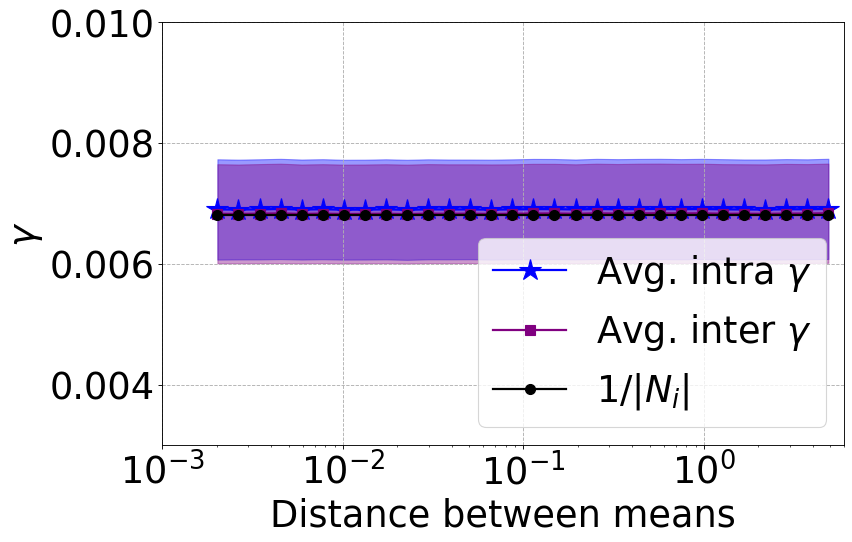

In [38]:
fig = plt.figure(figsize=(11, 7), dpi=80)

val = (2*np.sqrt(d))
plt.plot(mus*val,avg_gammas_intra, linewidth=2, linestyle='-', marker='*', markersize=20,  label='Avg. intra $\gamma$', color = 'blue')
plt.fill_between(mus*val,np.asarray(avg_gammas_intra)-np.asarray(std_gammas_intra),np.minimum(np.asarray(avg_gammas_intra)+np.asarray(std_gammas_intra),1),alpha=0.4, color = 'blue')

plt.plot(mus*val,avg_gammas_inter, linewidth=2, linestyle='-', marker='s', markersize=9,  label='Avg. inter $\gamma$', color = 'purple')
plt.fill_between(mus*val,np.asarray(avg_gammas_inter)-np.asarray(std_gammas_inter),np.minimum(np.asarray(avg_gammas_inter)+np.asarray(std_gammas_inter),1),alpha=0.4, color = 'purple')

gammas_gcn = 1/(1+0.5*n*(p+q))
    
plt.plot(mus*val,gammas_gcn*np.ones(len(mus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='$1/|N_i|$')

plt.grid(linestyle='dashed')
plt.legend(fontsize=33, loc='lower right')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=33)
plt.tick_params(axis='y', labelsize=33)
plt.xlabel('Distance between means', fontsize=33)
plt.ylabel('$\gamma$', fontsize=33)
plt.axis([0.001, 6, 0.003, 0.01])

fig.savefig("figures/noisy_edges_varying_distance_gammas.pdf", dpi=400, bbox_inches='tight')